Download packages

In [136]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
from sklego.meta import OrdinalClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from itertools import cycle, islice
import matplotlib.patches as mpatches
from sklearn.cluster import HDBSCAN, OPTICS, DBSCAN
import scipy



In [2]:
random.seed(8)

Create new feature names to take the mean and std across epochs pr person

In [3]:
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]
print(mean_list)

['Delta_mean', 'Delta_N_mean', 'Theta_mean', 'Theta_N_mean', 'Alpha_mean', 'Alpha_N_mean', 'Beta_mean', 'Beta_N_mean', 'Gamma_mean', 'Gamma_N_mean', 'SE_mean', 'MSF_mean', 'Sef90_mean', 'Sef95_mean', 'PE_mean', 'wSMI_mean', 'Kolmogorov_mean', 'MeanRR_mean', 'StdRR_mean', 'MeanHR_mean', 'StdHR_mean', 'MinHR_mean', 'MaxHR_mean']


Concatenate data

In [4]:
import sklearn.preprocessing


path ='CSV_individual_cross_val/'
folder = os.fsencode(path)
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]


patient_numbers = []
r_data = []
m_data = []
f_data = []

all_data = []


for file in os.listdir(folder):
    filename = os.fsdecode(file)
    patient_numbers.append(filename[0:3])
    fname = path + filename
    data = pd.read_csv(fname)
    data.columns = renamed_markers_list
    sklearn.preprocessing.StandardScaler().set_output(transform='pandas') 
    data[m_list] = sklearn.preprocessing.StandardScaler().fit(data[m_list]).transform(data[m_list]) #standardising data within each patient
    
    all_data.append(data)




In [103]:
#fit pca across patients
data_for_pca = pd.concat(all_data)
pca = sklearn.decomposition.PCA(n_components=0.95)
components = pca.fit(data_for_pca[m_list]).components_


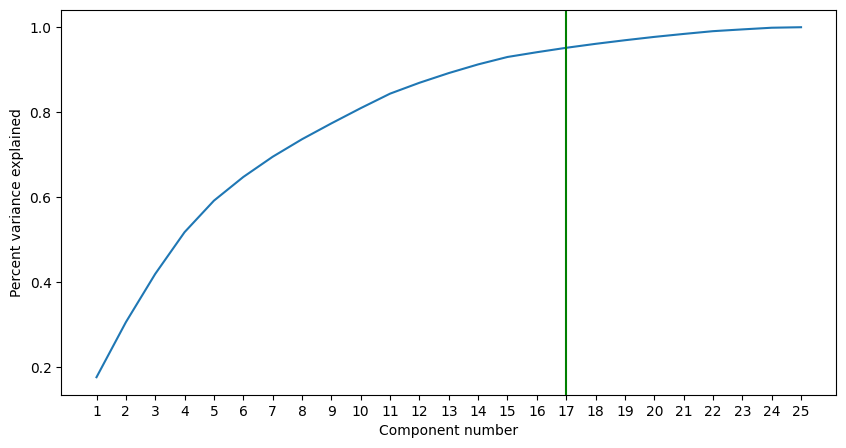

In [102]:
#done with all components
exp_var = pca.explained_variance_ratio_
plt.figure(figsize = (10, 5))
plt.plot(np.arange(1,26,1), exp_var.cumsum())
plt.xticks(np.arange(1,26,1))
plt.xlabel('Component number')
plt.ylabel('Percent variance explained')
plt.axvline(17, color='g')

In [16]:
print(components.shape)

(17, 25)


Ignore irrelevant warnings

In [17]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [18]:
print(patient_numbers)

['p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p27', 'p28', 'p29', 'p2_', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p3_', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p4_', 'p50', 'p51', 'p52', 'p53', 'p54', 'p56', 'p57', 'p58', 'p59', 'p5_', 'p60', 'p61', 'p62', 'p63', 'p65', 'p66', 'p67', 'p68', 'p69', 'p6_', 'p71', 'p72', 'p73', 'p74', 'p75', 'p77', 'p78', 'p79', 'p7_', 'p80', 'p8_', 'p9_']


Forward feature selection for each person to find relevant features

In [138]:
import sklearn.model_selection
A = set()
components_n = components.shape[0]
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

feat_scores = np.zeros(components_n)

for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    for j in range(components_n):
        skf = StratifiedKFold(n_splits=3)
        #print(np.array(train_X.iloc[:,j]))
        #print(np.array(train_y))
        scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,j]).reshape(-1, 1), np.array(train_y), cv = skf, scoring='balanced_accuracy')
        score = scores.sum()
        result = scipy.stats.ttest_1samp(scores, 1/3, alternative='greater')
        
        if score > 1.5:
            print('hurra person: ',i, 'has score: ', scores)
            A.add(i)
        feat_scores[j] += score

print(feat_scores)




hurra person:  0 has score:  [0.38888889 0.41666667 0.44444444]
hurra person:  0 has score:  [0.38888889 0.41666667 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  1 has score:  [0.47222222 0.58333333 0.44444444]
hurra person:  2 has score:  [0.47222222 0.38888889 0.44444444]
hurra person:  2 has score:  [0.41666667 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  2 has score:  [0.38888889 0.47222222 0.44444444]
hurra person:  2 has score:  [0.66666667 0.44444444 0.55555556]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  3 has score:  [0.41666667 0.5        0.44444444]
hurra person:  3 has score:  [0.5        0.38888889 0.44444444]
hurra person:  4 has score:  [0.44444444 0.38888889 0.44444444]
hurra person:  4 has score:  [0.38888889 0.5        0.44444444]
hurra person:  4 has score:  [0.38888889 0.5        0.44444444]
hurra person:  4 has score:  [0.58333333 0.47222222 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\A

hurra person:  5 has score:  [0.47222222 0.41666667 0.44444444]
hurra person:  6 has score:  [0.61111111 0.63888889 0.66666667]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  8 has score:  [0.38888889 0.41666667 0.44444444]
hurra person:  8 has score:  [0.47222222 0.47222222 0.44444444]
hurra person:  8 has score:  [0.38888889 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  9 has score:  [0.36111111 0.41666667 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  11 has score:  [0.5        0.41666667 0.44444444]
hurra person:  11 has score:  [0.41666667 0.38888889 0.44444444]
hurra person:  12 has score:  [0.38888889 0.38888889 0.44444444]
hurra person:  12 has score:  [0.58333333 0.41666667 0.66666667]
hurra person:  12 has score:  [0.44444444 0.55555556 0.66666667]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  13 has score:  [0.66666667 0.5        0.44444444]
hurra person:  13 has score:  [0.5        0.5        0.55555556]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\A

hurra person:  15 has score:  [0.47222222 0.41666667 0.55555556]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  15 has score:  [0.5        0.38888889 0.44444444]
hurra person:  16 has score:  [0.5        0.38888889 0.55555556]
hurra person:  16 has score:  [0.5        0.47222222 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  17 has score:  [0.38888889 0.38888889 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\A

hurra person:  19 has score:  [0.47222222 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  22 has score:  [0.5        0.5        0.55555556]
hurra person:  22 has score:  [0.41666667 0.41666667 0.44444444]
hurra person:  22 has score:  [0.38888889 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  25 has score:  [0.47222222 0.5        0.55555556]
hurra person:  25 has score:  [0.41666667 0.47222222 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  26 has score:  [0.5        0.41666667 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\A

hurra person:  28 has score:  [0.58333333 0.47222222 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  29 has score:  [0.41666667 0.38888889 0.44444444]
hurra person:  30 has score:  [0.38888889 0.41666667 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  31 has score:  [0.55555556 0.66666667 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  32 has score:  [0.41666667 0.38888889 0.44444444]
hurra person:  33 has score:  [0.47222222 0.38888889 0.44444444]
hurra person:  34 has score:  [0.5        0.38888889 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  35 has score:  [0.66666667 0.5        0.44444444]
hurra person:  35 has score:  [0.5        0.55555556 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  37 has score:  [0.5        0.38888889 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  38 has score:  [0.38888889 0.41666667 0.44444444]
hurra person:  38 has score:  [0.58333333 0.58333333 0.55555556]
hurra person:  39 has score:  [0.41666667 0.38888889 0.44444444]
hurra person:  39 has score:  [0.41666667 0.47222222 0.44444444]
hurra person:  39 has score:  [0.47222222 0.38888889 0.44444444]
hurra person:  39 has score:  [0.47222222 0.47222222 0.55555556]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  43 has score:  [0.47222222 0.38888889 0.44444444]
hurra person:  44 has score:  [0.5        0.38888889 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  45 has score:  [0.38888889 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  47 has score:  [0.5        0.41666667 0.44444444]
hurra person:  47 has score:  [0.41666667 0.38888889 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  49 has score:  [0.55555556 0.55555556 0.55555556]
hurra person:  51 has score:  [0.58333333 0.41666667 0.55555556]
hurra person:  51 has score:  [0.41666667 0.44444444 0.44444444]
hurra person:  51 has score:  [0.38888889 0.5        0.44444444]
hurra person:  52 has score:  [0.58333333 0.47222222 0.44444444]
hurra person:  52 has score:  [0.47222222 0.5        0.55555556]
hurra person:  52 has score:  [0.38888889 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  56 has score:  [0.47222222 0.41666667 0.44444444]
hurra person:  57 has score:  [0.41666667 0.38888889 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  59 has score:  [0.47222222 0.5        0.44444444]
hurra person:  59 has score:  [0.41666667 0.41666667 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  59 has score:  [0.41666667 0.41666667 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\KSOE0397\A

hurra person:  65 has score:  [0.41666667 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  66 has score:  [0.41666667 0.5        0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  67 has score:  [0.38888889 0.47222222 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  68 has score:  [0.47222222 0.38888889 0.44444444]
hurra person:  68 has score:  [0.38888889 0.38888889 0.44444444]
hurra person:  69 has score:  [0.5        0.38888889 0.44444444]


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


hurra person:  70 has score:  [0.5        0.47222222 0.44444444]
hurra person:  72 has score:  [0.58333333 0.41666667 0.55555556]
[78.27777778 71.         75.02777778 74.72222222 76.19444444 72.83333333
 73.27777778 77.41666667 73.08333333 72.02777778 72.38888889 73.08333333
 75.52777778 73.16666667 79.11111111 76.72222222 74.05555556]


In [76]:
1/3*(10/10)
[2,6,9,12,13,22,25,30,31,32,34,35,38,49,51,52,55,62,72]

0.3333333333333333

In [21]:
first_feature = np.argmax(feat_scores)

In [22]:
print(pca.explained_variance_ratio_)

[0.17568396 0.12957078 0.11373468 0.09834585 0.07417183 0.05575638
 0.04762804 0.04130942 0.03730857 0.035867   0.03417238 0.02561078
 0.02285688 0.02044259 0.01747215 0.01119912 0.01041772]


0.01747215, 0.00785092

In [23]:
print(first_feature)

14


In [84]:

t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)
B = set()
feat_scores_r2 = np.zeros(components_n)
for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    for j in range(components_n):
        if j != first_feature:

            skf = StratifiedKFold(n_splits=3)
            #print(np.array(train_X.iloc[:,j]))
            #print(np.array(train_y))
            scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,[first_feature,j]]), np.array(train_y), cv = skf, scoring='balanced_accuracy')
            score = scores.sum()

            if score > 1:
                print('hurra person: ',i, 'has score: ', scores)
                B.add(i)
            feat_scores_r2[j] += score


hurra person:  1 has score:  [0.44444444 0.55555556 0.55555556]
hurra person:  2 has score:  [0.58333333 0.44444444 0.55555556]
hurra person:  2 has score:  [0.66666667 0.36111111 0.55555556]
hurra person:  2 has score:  [0.58333333 0.44444444 0.55555556]
hurra person:  2 has score:  [0.66666667 0.44444444 0.44444444]
hurra person:  6 has score:  [0.72222222 0.75       0.77777778]
hurra person:  7 has score:  [0.41666667 0.58333333 0.55555556]
hurra person:  12 has score:  [0.44444444 0.66666667 0.44444444]
hurra person:  13 has score:  [0.38888889 0.5        0.66666667]
hurra person:  13 has score:  [0.41666667 0.5        0.66666667]
hurra person:  13 has score:  [0.5        0.58333333 0.44444444]
hurra person:  13 has score:  [0.5        0.58333333 0.55555556]
hurra person:  16 has score:  [0.58333333 0.38888889 0.66666667]
hurra person:  25 has score:  [0.47222222 0.5        0.55555556]
hurra person:  30 has score:  [0.47222222 0.55555556 0.66666667]
hurra person:  31 has score:  [0

In [89]:
# union 
print("Union :", sorted(A | B), len(A | B)) 
  
# intersection 
print("Intersection :", sorted(A & B), len(A & B)) 
  
# difference 
print("Difference first-second round:", sorted(A - B), len(A - B)) 
print("Difference second-first round:", sorted(B - A), len(B - A)) 



Union : [1, 2, 6, 7, 9, 12, 13, 16, 22, 25, 30, 31, 32, 34, 35, 38, 39, 44, 46, 49, 51, 52, 53, 55, 58, 62, 64, 71, 72] 29
Intersection : [2, 6, 12, 13, 25, 30, 31, 32, 35, 38, 49, 55] 12
Difference first-second round: [9, 22, 34, 51, 52, 62, 72] 7
Difference second-first round: [1, 7, 16, 39, 44, 46, 53, 58, 64, 71] 10


In [91]:
persons_from_cross_val = [patient_numbers[i] for i in sorted(A | B)]
print(persons_from_cross_val)

['p11', 'p12', 'p16', 'p17', 'p19', 'p22', 'p23', 'p27', 'p32', 'p35', 'p3_', 'p40', 'p41', 'p43', 'p44', 'p47', 'p48', 'p52', 'p54', 'p58', 'p5_', 'p60', 'p61', 'p63', 'p67', 'p71', 'p73', 'p80', 'p8_']


In [26]:

print(feat_scores_r2)
print(np.argmax(feat_scores_r2))
second_feature = np.argmax(feat_scores_r2) 

[78.63888889 76.61111111 78.08333333 77.97222222 79.22222222 75.80555556
 75.44444444 79.38888889 77.47222222 74.55555556 76.66666667 76.27777778
 77.86111111 75.80555556  0.         77.16666667 77.55555556]
7


In [27]:
sort1 = np.argsort(abs(np.array(components[first_feature])))[::-1]
sort2 = np.argsort(abs(np.array(components[second_feature])))[::-1]
#print([(components[0][i], m_list[i]) for i in range(25)])
#print(components[0])
print([(m_list[j], components[first_feature][j]) for j in sort1[0:5]])
print([(m_list[j], components[second_feature][j]) for j in sort2[0:5]])

[('MSF', -0.5026683070878373), ('Delta_N', 0.4357339048069173), ('Beta', 0.38218004685788043), ('Kolmogorov', 0.360372700718073), ('Delta', -0.33962736647448893)]
[('freq_slope_std', 0.5314301039538447), ('Theta_N', -0.3538484373075634), ('Alpha_N', 0.3429574636105816), ('Alpha', 0.31358653372845163), ('freq_slope_mean', -0.2826093147558914)]


# Clustering begin

In [28]:
r_data = []
m_data = []
f_data = []
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]

for data in all_data:
    R_indicesToKeep = data['Event'] == 'R'
    df_r = data.loc[R_indicesToKeep]

    M_indicesToKeep = data['Event'] == 'M'
    df_m = data.loc[M_indicesToKeep]

    F_indicesToKeep = data['Event'] == 'F'
    df_f = data.loc[F_indicesToKeep]

    r_mean = pd.DataFrame(df_r[m_list].mean(axis=0)).transpose()
    m_mean = pd.DataFrame(df_m[m_list].mean(axis=0)).transpose()
    f_mean = pd.DataFrame(df_f[m_list].mean(axis=0)).transpose()

    r_mean.columns = mean_list
    m_mean.columns = mean_list
    f_mean.columns = mean_list

    r_std = pd.DataFrame(df_r[m_list].std(axis=0)).transpose()
    m_std = pd.DataFrame(df_m[m_list].std(axis=0)).transpose()
    f_std = pd.DataFrame(df_f[m_list].std(axis=0)).transpose()
        
    r_std.columns = std_list
    m_std.columns = std_list
    f_std.columns = std_list
    
    rest = pd.concat([r_mean,r_std],axis=1).to_numpy()
    med = pd.concat([m_mean,m_std],axis=1).to_numpy()
    fam = pd.concat([f_mean,f_std],axis=1).to_numpy()

    r_data.append(rest[0])
    m_data.append(med[0])
    f_data.append(fam[0])

In [29]:
X = [f_data[i] - r_data[i] for i in range(len(r_data))] + [m_data[i] - r_data[i] for i in range(len(r_data))]
y = [i for i in range(0,len(r_data))] + [i for i in range(0,len(r_data))]


In [30]:
print(X[1])

[-0.33710532  0.31548322 -0.23641053  0.35965734 -0.7606652  -0.45673387
 -0.20020842 -0.48888733 -0.15858671  0.01208512  0.7034125  -0.59233464
 -0.07307819 -0.34579794  0.61600264  1.06692778  0.63469221 -0.10310031
  0.28480272  0.10858177  0.35146834 -0.22349345  0.31226754  0.57165976
 -0.1145396  -0.7110702   0.49839018 -0.92926963  0.7477205   0.50559053
 -0.78373675  0.42583334 -1.13212678  0.18000861  0.28899828  0.62777988
 -0.73446541  0.093115    0.24347972  0.97875626  0.90875732  0.79535944
 -0.32316299  0.439588   -0.29471174  0.46097894  0.27983259  0.10024913
 -0.21333517 -0.46524138]


### pca transform data

In [31]:
warnings.filterwarnings(action='ignore', category=UserWarning)
X_pca = [np.append(pca.transform(X[i][0:25].reshape(1,-1)),pca.transform(X[i][25:].reshape(1,-1))) for i in range(len(X))]

In [32]:
X_pca

[array([ 0.46488596, -2.68166578,  1.21290012,  1.48636303, -1.04586221,
         0.49485948,  0.97803103, -0.40695936, -0.54557097, -1.55535848,
        -1.47763974,  0.34566074,  0.79170686,  0.7990463 ,  0.04283358,
         0.01628119, -0.13767486, -0.49387764, -1.35781333, -0.23768222,
        -1.20013649, -0.09898067, -0.14975689,  0.28520296,  1.15781576,
        -0.68807321, -0.65272164, -0.61225528, -0.86412585,  0.84240246,
         0.83975248, -0.10759516, -0.34680633, -0.54891715]),
 array([-0.82811616,  0.72237722, -0.0234423 ,  0.46845134, -0.61508259,
         0.13403962,  0.07844833, -0.19609752,  0.71397656,  1.26088834,
         0.1563655 ,  0.42644826, -0.15739411, -0.21899618,  0.33267716,
        -0.69036898,  0.02378754, -0.35111345,  0.92260062, -0.06021098,
         0.44697389, -0.36675785,  0.28966885, -0.28837489, -0.04592309,
         0.86786033,  0.52562979, -0.40761102,  0.79802077, -0.70373512,
        -0.47708409,  1.07826863, -1.07352257, -0.29955146]),


In [36]:
X_pca_array = np.asarray(X_pca)
print(X_pca_array.shape)

(148, 34)


### take chosen components from data and fit clustering algorithms

In [104]:
b= mean_list+std_list
min_size = 5
chosen_features = [first_feature, second_feature]
ind = [True if i in chosen_features else False for i in range(components_n)] + [True if i in chosen_features else False for i in range(components_n)]
X_pca_chosen = X_pca_array[:,ind]   
    
sclustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_pca_chosen)
sy_pred = sclustering.labels_
hdb = HDBSCAN(min_cluster_size=min_size).fit(X_pca_chosen)
hy_pred = hdb.labels_
patient_numbers2 = patient_numbers+patient_numbers

dclustering = DBSCAN(min_samples=min_size).fit(X_pca_chosen)
dy_pred = dclustering.labels_    

oclustering = OPTICS(min_samples=min_size).fit(X_pca_chosen)
oy_pred = oclustering.labels_

### plot clustering

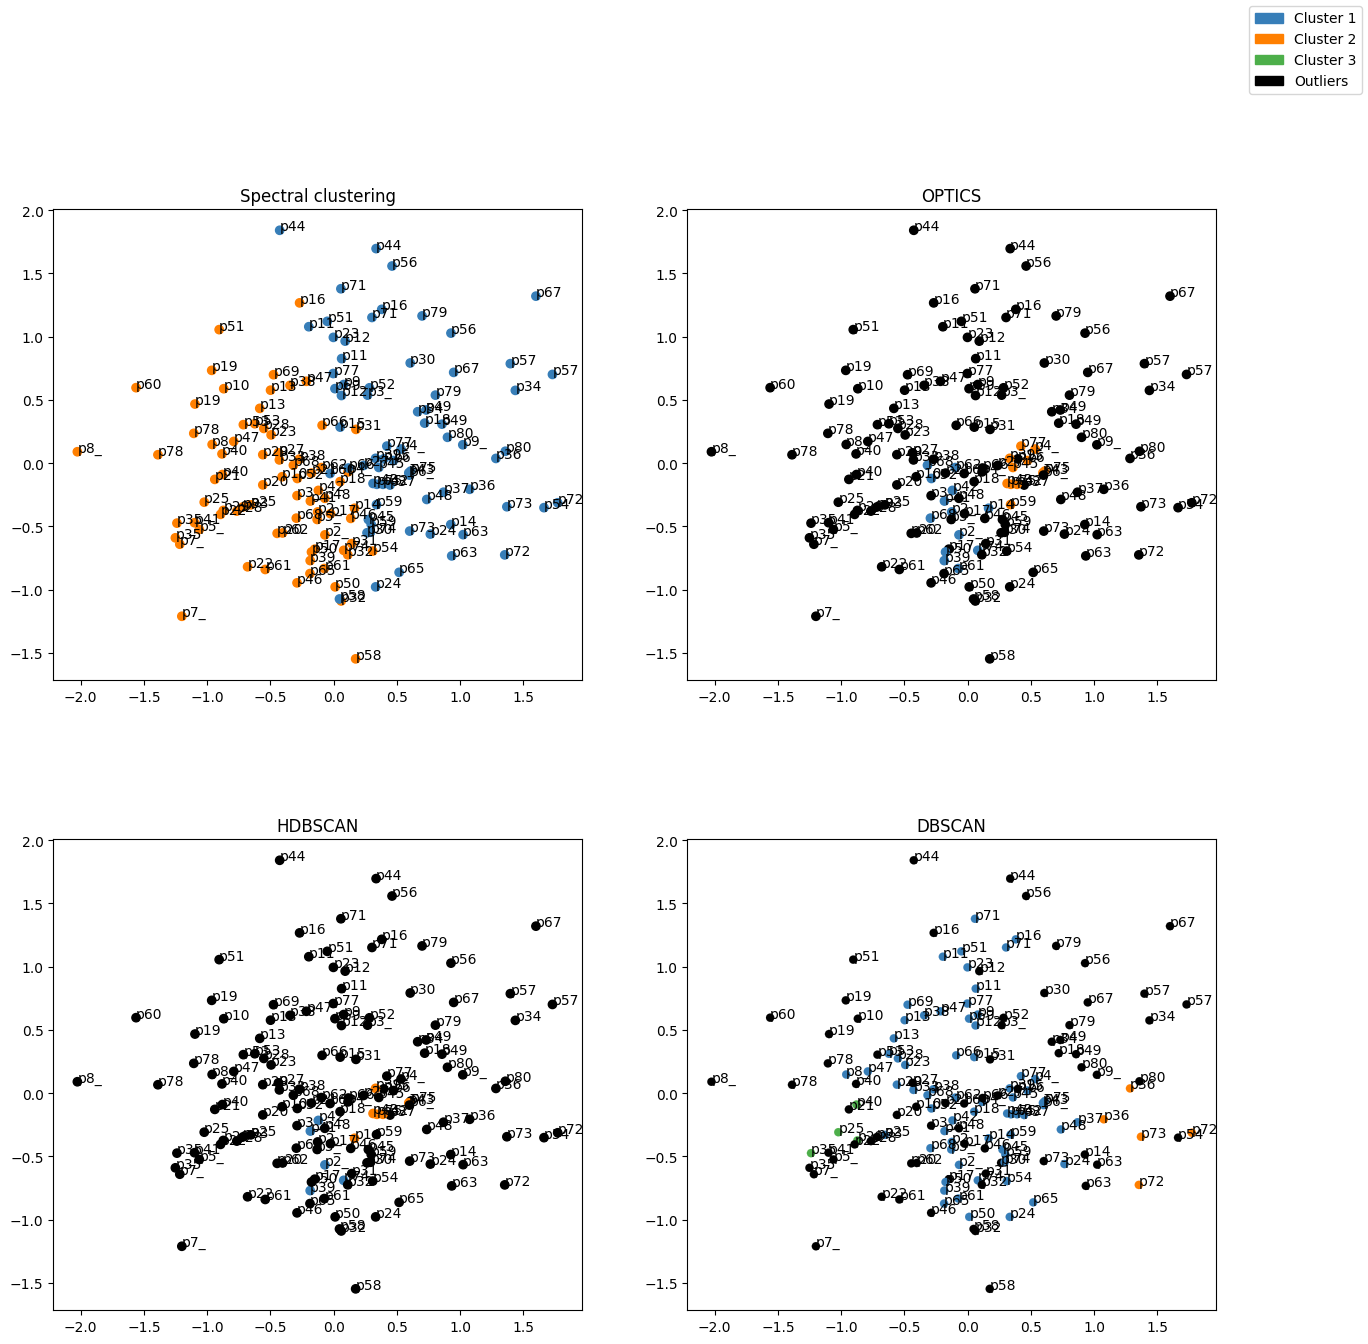

In [135]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a", 
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                ]
            ),
            int(max(np.concatenate((dy_pred, hy_pred, oy_pred, sy_pred)))+1),
        )
    )
)

# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
ax[0,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[sy_pred])
for i, txt in enumerate(y):
    ax[0,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[0,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,0].set_title('Spectral clustering')

ax[0,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[oy_pred])
for i, txt in enumerate(y):
    ax[0,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[0,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,1].set_title('OPTICS')
#ax[0,1].legend()


ax[1,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[hy_pred])
for i, txt in enumerate(y):
    ax[1,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[1,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,0].set_title('HDBSCAN')
#ax[1,0].legend()

ax[1,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[dy_pred], linewidth = 0.1)
for i, txt in enumerate(y):
    ax[1,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[1,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,1].set_title('DBSCAN')
#ax[1,1].legend()
pop_a = mpatches.Patch(color="#377eb8", label='Cluster 1') 
pop_b = mpatches.Patch(color="#ff7f00", label='Cluster 2')
pop_d = mpatches.Patch(color="#4daf4a", label='Cluster 3')
pop_c = mpatches.Patch(color="#000000", label='Outliers')
fig.legend(handles=[pop_a,pop_b,pop_d,pop_c]) 

Text(0.5, 1.0, 'DBSCAN')

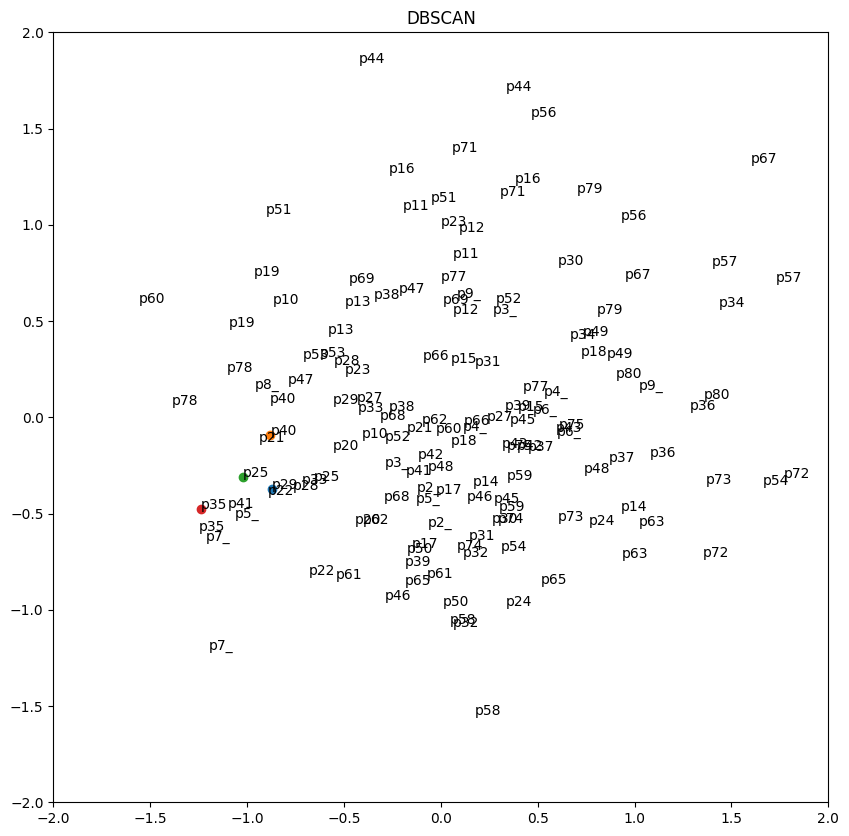

In [128]:
plt.figure(figsize=(10,10))
for i in range(len(dy_pred)):
    if dy_pred[i] == 2:
        plt.scatter(X_pca_chosen[i, 0], X_pca_chosen[i, -1])
for i, txt in enumerate(y):
    plt.annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
plt.xlim(-2,2)
plt.ylim(-2,2)
#plt.aspect('equal', adjustable=None, anchor=None, share=False)
plt.title('DBSCAN')

### find different cluster groups

In [106]:
#adding wether it is familiar-resting or unfamiliar-resting datapoint
patient_numbers_with_event = [patient_num +'-fr' for patient_num in patient_numbers] + [patient_num +'-mr' for patient_num in patient_numbers] 

In [107]:
#finding each label for each patient
sy_groups = [(sy_pred[i], patient_numbers_with_event[i]) for i in range(len(sy_pred))]
oy_groups = [(oy_pred[i], patient_numbers_with_event[i]) for i in range(len(oy_pred))]
hy_groups = [(hy_pred[i], patient_numbers_with_event[i]) for i in range(len(hy_pred))]
dy_groups = [(dy_pred[i], patient_numbers_with_event[i]) for i in range(len(dy_pred))]

In [108]:
#cluster sizes
sy_groups_counts = list(zip(*np.unique(sy_pred, return_counts=True)))
oy_groups_counts = list(zip(*np.unique(oy_pred, return_counts=True)))
hy_groups_counts = list(zip(*np.unique(hy_pred, return_counts=True)))
dy_groups_counts = list(zip(*np.unique(dy_pred, return_counts=True)))
print(sy_groups_counts)
print(oy_groups_counts)
print(hy_groups_counts)
print(dy_groups_counts)

[(0, 71), (1, 77)]
[(-1, 124), (0, 13), (1, 11)]
[(-1, 137), (0, 5), (1, 6)]
[(-1, 72), (0, 67), (1, 5), (2, 4)]


In [66]:
#cluster sorted
sort_sy = sorted(sy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_oy = sorted(oy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_hy = sorted(hy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_dy = sorted(dy_groups, key = lambda x: (x[0],x[1]))[::-1]
print(sort_sy)
print(sort_oy)
print(sort_hy)
print(sort_dy)

[(1, 'p8_-mr'), (1, 'p8_-fr'), (1, 'p7_-mr'), (1, 'p7_-fr'), (1, 'p78-mr'), (1, 'p78-fr'), (1, 'p74-fr'), (1, 'p69-mr'), (1, 'p68-mr'), (1, 'p68-fr'), (1, 'p66-fr'), (1, 'p65-mr'), (1, 'p62-mr'), (1, 'p62-fr'), (1, 'p61-mr'), (1, 'p61-fr'), (1, 'p60-mr'), (1, 'p5_-mr'), (1, 'p5_-fr'), (1, 'p58-fr'), (1, 'p54-fr'), (1, 'p53-mr'), (1, 'p53-fr'), (1, 'p52-fr'), (1, 'p51-fr'), (1, 'p50-mr'), (1, 'p50-fr'), (1, 'p4_-mr'), (1, 'p48-mr'), (1, 'p47-mr'), (1, 'p47-fr'), (1, 'p46-mr'), (1, 'p46-fr'), (1, 'p42-fr'), (1, 'p41-mr'), (1, 'p41-fr'), (1, 'p40-mr'), (1, 'p40-fr'), (1, 'p3_-fr'), (1, 'p39-fr'), (1, 'p38-mr'), (1, 'p38-fr'), (1, 'p35-mr'), (1, 'p35-fr'), (1, 'p33-mr'), (1, 'p33-fr'), (1, 'p32-mr'), (1, 'p32-fr'), (1, 'p31-mr'), (1, 'p31-fr'), (1, 'p2_-mr'), (1, 'p2_-fr'), (1, 'p29-mr'), (1, 'p29-fr'), (1, 'p28-mr'), (1, 'p28-fr'), (1, 'p27-mr'), (1, 'p25-mr'), (1, 'p25-fr'), (1, 'p23-mr'), (1, 'p22-mr'), (1, 'p22-fr'), (1, 'p21-mr'), (1, 'p21-fr'), (1, 'p20-mr'), (1, 'p20-fr'), (1, 'p19-

### plot patients that are outliers/in smaller group from dbscan

In [67]:
outliers_dy = [(-1, 'p9_-mr'), (-1, 'p8_-mr'), (-1, 'p80-mr'), (-1, 'p80-fr'), (-1, 'p7_-mr'), (-1, 'p7_-fr'), (-1, 'p79-mr'), (-1, 'p79-fr'), (-1, 'p78-mr'), (-1, 'p78-fr'), (-1, 'p73-mr'), (-1, 'p67-mr'), (-1, 'p67-fr'), (-1, 'p66-mr'), (-1, 'p63-mr'), (-1, 'p63-fr'), (-1, 'p62-fr'), (-1, 'p61-fr'), (-1, 'p60-mr'), (-1, 'p60-fr'), (-1, 'p5_-fr'), (-1, 'p58-mr'), (-1, 'p58-fr'), (-1, 'p57-mr'), (-1, 'p57-fr'), (-1, 'p56-mr'), (-1, 'p56-fr'), (-1, 'p54-mr'), (-1, 'p53-fr'), (-1, 'p52-mr'), (-1, 'p51-fr'), (-1, 'p49-mr'), (-1, 'p49-fr'), (-1, 'p48-mr'), (-1, 'p46-mr'), (-1, 'p46-fr'), (-1, 'p44-mr'), (-1, 'p44-fr'), (-1, 'p41-mr'), (-1, 'p40-mr'), (-1, 'p3_-mr'), (-1, 'p3_-fr'), (-1, 'p35-fr'), (-1, 'p34-mr'), (-1, 'p34-fr'), (-1, 'p33-mr'), (-1, 'p32-mr'), (-1, 'p32-fr'), (-1, 'p31-mr'), (-1, 'p31-fr'), (-1, 'p30-mr'), (-1, 'p30-fr'), (-1, 'p28-fr'), (-1, 'p27-mr'), (-1, 'p27-fr'), (-1, 'p22-mr'), (-1, 'p22-fr'), (-1, 'p21-mr'), (-1, 'p21-fr'), (-1, 'p20-mr'), (-1, 'p20-fr'), (-1, 'p19-mr'), (-1, 'p19-fr'), (-1, 'p18-fr'), (-1, 'p17-mr'), (-1, 'p17-fr'), (-1, 'p16-fr'), (-1, 'p15-fr'), (-1, 'p14-fr'), (-1, 'p12-fr'), (-1, 'p10-mr'), (-1, 'p10-fr')]
patient_data_pca = []
patients_in_group = []
patients_in_group_counts = []
for _, patient in outliers_dy:
    patient = patient[:3]
    patients_in_group_counts.append(patient)
    if patient not in patients_in_group:
        patients_in_group.append(patient)
        patient_ind = patient_numbers.index(patient)
        train_X = all_data[patient_ind][m_list]
        train_X = pca.transform(train_X)
        train_X = pd.DataFrame(train_X)
        patient_data_pca.append(train_X)

patients_in_group_counts = list(zip(*np.unique(patients_in_group_counts, return_counts=True)))
sort_p_counts = sorted(patients_in_group_counts, key = lambda x: x[1])[::-1]
print(sort_p_counts)


[('p80', 2), ('p7_', 2), ('p79', 2), ('p78', 2), ('p67', 2), ('p63', 2), ('p60', 2), ('p58', 2), ('p57', 2), ('p56', 2), ('p49', 2), ('p46', 2), ('p44', 2), ('p3_', 2), ('p34', 2), ('p32', 2), ('p31', 2), ('p30', 2), ('p27', 2), ('p22', 2), ('p21', 2), ('p20', 2), ('p19', 2), ('p17', 2), ('p10', 2), ('p9_', 1), ('p8_', 1), ('p73', 1), ('p66', 1), ('p62', 1), ('p61', 1), ('p5_', 1), ('p54', 1), ('p53', 1), ('p52', 1), ('p51', 1), ('p48', 1), ('p41', 1), ('p40', 1), ('p35', 1), ('p33', 1), ('p28', 1), ('p18', 1), ('p16', 1), ('p15', 1), ('p14', 1), ('p12', 1)]


In [68]:
print(len(sort_p_counts))

47


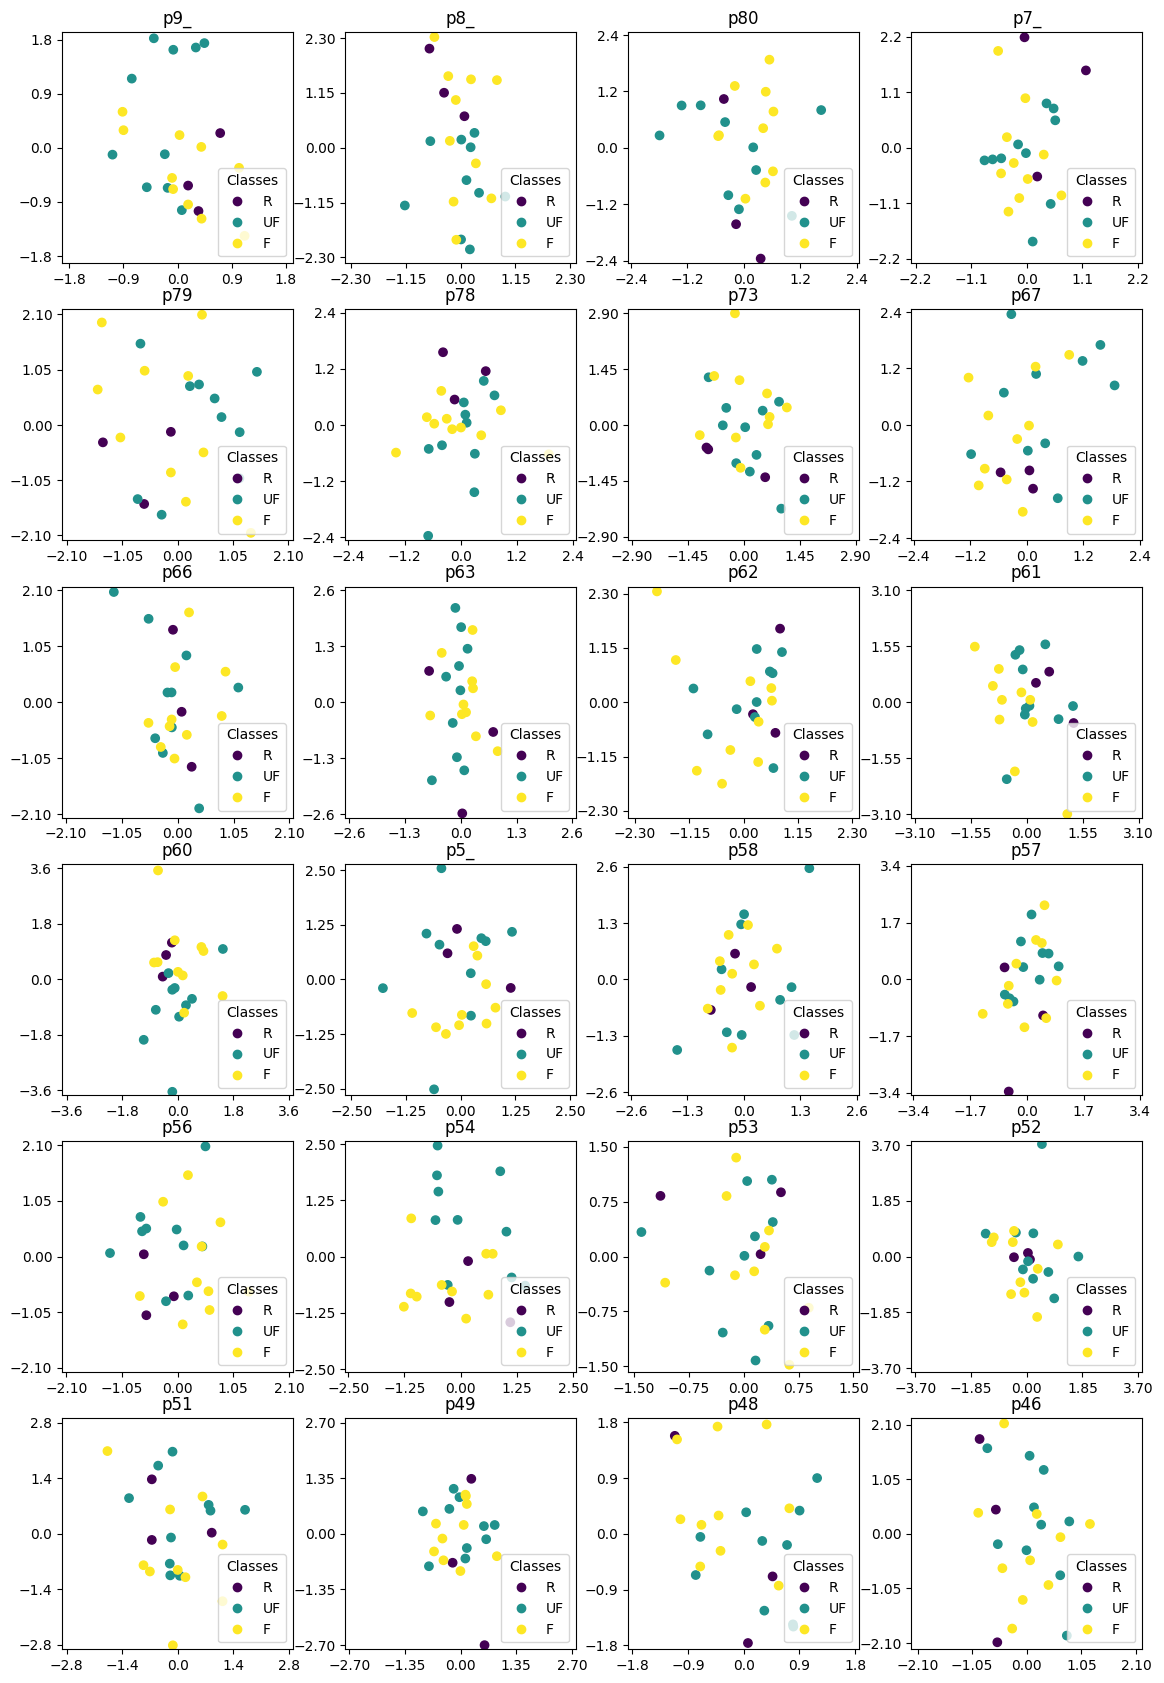

In [93]:
fig, axes = plt.subplots(6,4, figsize=(14,21))
for i,ax in zip(range(len(patients_in_group)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)

    scatter = ax.scatter(patient_data_pca[i][first_feature], patient_data_pca[i][second_feature], c=y1)
    max_val = np.max(np.append(abs(patient_data_pca[i][first_feature]),abs(patient_data_pca[i][second_feature]))) 
    ax.set_ylim(-max_val-0.1,max_val+0.1)
    ax.set_xlim(-max_val-0.1,max_val+0.1)
    ax.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    ax.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])

    ax.set_aspect('equal', adjustable=None, anchor=None, share=False)
    ax.legend(
        scatter.legend_elements()[0],
        ['R', 'UF', 'F'],
        title="Classes",
        loc = 'lower right'
    )
    ax.set_title(patients_in_group[i])

